# Rigorous estimates of p-laplacian's first eigenvalue using interval arithmetic

In [1]:
using DifferentialEquations
using Plots; gr()
using IntervalArithmetic
using DataInterpolations
using LinearAlgebra
using ForwardDiff

In [2]:
"""
Vypočítá numerické řešení p-laplaciánu.

Vstupní parametry:
λi ... interval na kterém hledám λ₁
P ... p z p-laplaciánu
n ... počet kroků dělení

Výstupní hodnoty:
t, tᴵ ... body dělení (Float64, Interval) časové osy
U₁, U₁ᴵ  ... bodové a intervalové hodnoty řešení u₁ v t
U₂, U₂ᴵ ... intervalové a bodové řešení u2
Λ₁ ... numerický odhad λ₁
"""
function plaplace_solve(λi, p, n; plt_res=true, u2_0=1.0)
   
    function sl(du,u,P,t) # parametr p je odhad na λ₁ a p z p-laplacianu
        λ, p = P
        du[1] = abs(u[2])^(1/(p-1)) * sign(u[2])
        du[2] = -λ * abs(u[1])^(p-1)*sign(u[1]) 
    end

    u0 = [0.0; u2_0;] # počáteční podmínka
    a, b = λi
    Λ₁ = (a + b)/2
    Δt = 1.0/(n-1) # velikost intervalu dělení
    e = 1e-12 # zastavovací podmínka

    while (b-a) >= e
        prob = ODEProblem(sl, u0, (0.0, 1.0), (Λ₁, p))
        sol = solve(prob, saveat=Δt, abstol=1e-8,reltol=1e-8)
        if sol(1)[1] == 0 # hodnota u₁ v t=1
            break
        else
            probA = ODEProblem(sl, u0, (0.0, 1.0), (a, p))
            solA = solve(probA, saveat=Δt, abstol=1e-8,reltol=1e-8)
            probS = ODEProblem(sl, u0, (0.0, 1.0), (Λ₁, p))
            solS = solve(probS, saveat=Δt, abstol=1e-8,reltol=1e-8)
            if solA(1)[1] * solS(1)[1] < 0
                b = Λ₁
            else
                a = Λ₁
            end
            Λ₁ = (a+b)/2
        end
    end

    prob = ODEProblem(sl, u0, (0.0, 1.0), (Λ₁, p))
    sol = solve(prob, saveat=Δt, abstol=1e-8,reltol=1e-8)

    if plt_res
        println("Numericky získané první vlastní číslo Λ₁=$(Λ₁)")
        display(plot(sol,marker=2))
    end
    
    t = sol.t
    tᴵ = [@interval(i) for i in t]
    U₁ = [u[1] for u in sol.u]
    U₁[end] = 0
    U₁ᴵ = [@interval(u[1]) for u in sol.u]
    U₁ᴵ[end] = 0..0
    U₂ = [u[2] for u in sol.u]
    U₂ᴵ = [@interval(u[2]) for u in sol.u]
    
    return t, tᴵ, U₁, U₁ᴵ, U₂, U₂ᴵ, Λ₁
end;

In [3]:
"""
Intervalově zadané řídící body proloží intervalově kubickým splinem.

Vstupní parametry:
t, tᴵ         ... bodové a intervalové dělení časové osy
U, Uᴵ         ... body a intervaly které prokláme splinem
Uₗd2, Uᵣd2    ... hodnoty druhé derivace v krajních (levý, pravý) bodech
plt_res=true  ... vykreslení řešení
ns=10         ... dělení jednotlivých oblouků kubického splinu

Výstupní hodnoty:
csc_u ... koeficienty kubického splinu
Uˢ   ... intervalové hodnoty splinu v bodech dělení
"""
function cubic_spline(t, tᴵ, U, Uᴵ, Uₗd2, Uᵣd2; plt_res=true, ns=10)
    #matice A
    n=length(Uᴵ)
    dv = [4..4 for i in 1:n-2]
    ev = [1..1 for i in 1:n-3]
    A = Array(SymTridiagonal(dv,ev))
    A⁻¹ = inv(A)

    #pravá strana
    h = 1.0/(n-1)
    rhs = []
    for i in 3:length(Uᴵ)
        append!(rhs, 6/h^2 * (Uᴵ[i] - 2 * Uᴵ[i-1] + Uᴵ[i-2]))
    end
    
    rhs[1] = rhs[1]-Uₗd2
    rhs[end] = rhs[end]-Uᵣd2    

    # vektor druhých derivací  
    Ud2 = []
    append!(Ud2, @interval(Uₗd2))
    append!(Ud2, A⁻¹*rhs)
    append!(Ud2, @interval(Uᵣd2))

    # koeficienty jednotlivých oblouků splinu
    csc_U = []
    for i in 1:length(Uᴵ)-1
        a=b=c=d=0
        a = (Ud2[i+1]-Ud2[i])/(6*h)
        b = Ud2[i]/2 
        c = (Uᴵ[i+1] - Uᴵ[i])/h - h*(2*Ud2[i]+Ud2[i+1])/6
        d = Uᴵ[i]
        append!(csc_U, [[a,b,c,d]])
    end 
    

    if plt_res
        res_plot = plot(t, U, marker=2)
    end
    Uˢ = Interval[] # intervalově vyjádřený spline 
    for i in 1:length(Uᴵ)-1
        x_dom = t[i]..t[i+1]
        x_int = mince(x_dom,ns)
        f(x) = csc_U[i][1]*(x-t[i])^3 + csc_U[i][2]*(x-t[i])^2 + csc_U[i][3]*(x-t[i]) + csc_U[i][4]
        append!(Uˢ, f.(x_int))
        if plt_res
            boxes = IntervalBox.(x_int, f.(x_int))    
            plot!(boxes, legend=false)
        end
    end
    if plt_res display(res_plot) end
        
    return csc_U, Uˢ
end;

In [4]:
"""
Z intervalově vyjádřeného splinu U₂ᴵ rekonstruuje intervalově vyjádřené U₁ˢ.

Vstupní parametry:
p             ... hodnota p z p-laplaciánu
U₂ˢ           ... intervalové hodnoty splinu u₂ v bodech dělení
t             ... bodové dělení časové osy
U₁            ... bodové numerické hodnoty u₁ 
plt_res=true  ... vykreslení řešení


Výstupní hodnoty:
U₁ˢ  ... intervalové hodnoty u₁ v bodech dělení
"""
function get_u1(p, U₂ˢ, t, U₁; plt_res=true, δ=-1.0)
    
    f(x) = abs(x)^(1/(p-1))*sign(x)
    ni = mince(0..1,length(U₂ˢ))

    U₁_tmp = Interval[0..0]
    for i in 1:length(U₂ˢ)
        append!(U₁_tmp, U₁_tmp[end] + f(U₂ˢ[i]) * diam(ni[i]))
    end
    
    U₁ˢ = Interval[]
    for i in 1:length(U₁_tmp)-1
        append!(U₁ˢ, U₁_tmp[i] ∪ U₁_tmp[i+1])
    end
    
    if δ == -1
        δ = inf(minimum(U₁ˢ))
        if δ > 0
            U₁ˢ = U₁ˢ .- (δ - δ*1e-8)
        else
            U₁ˢ = U₁ˢ .+ (-δ - δ*1e-8)
        end
    else
        U₁ˢ  = U₁ˢ .+ δ
    end

    if plt_res
        x_int = mince(0..1,length(U₁ˢ))
        boxes = IntervalBox.(x_int, U₁ˢ)
        plot(boxes)
        display(plot!(t, U₁, marker=2, legend=false))
    end
    
    return U₁ˢ
    
end;

In [5]:
"""
Z koeficientů intervalově vypočítá derivaci kubického splinu

Vstupní parametry:
csc           ... koeficienty splinu
t, tᴵ         ... bodové i intervalově dělení časové osy
ns            ... počet bodů dělení jednotlivého oblouku splinu
plt_res=true  ... vykreslení řešení


Výstupní hodnoty:
Uˢ   ... intervalové hodnoty derivace splinu

"""
function der_cubic_spline(csc, t, tᴵ, ns; plt_res = true)
    
    Uₜₘₚ = Interval[]
    csc_Uder = [ [@interval(3) * c[1], @interval(2) * c[2], c[3]] for c in csc ] 
    for i in 1:length(t)-1
        x_dom = t[i]..t[i+1] 
        x_int = mince(x_dom,ns)
        f(x) = csc_Uder[i][1]*(x-t[i])^2 + csc_Uder[i][2]*(x-t[i]) + csc_Uder[i][3]
        append!(Uₜₘₚ, f.(x_int))
    end
    
    Uˢ = Interval[]
    for i in 1:length(Uₜₘₚ)-1
        append!(Uˢ, Uₜₘₚ[i] ∪ Uₜₘₚ[i+1])
    end
    append!(Uˢ,Uₜₘₚ[end])
    
    if plt_res
        x_int = mince(0..1,length(Uˢ))
        display(plot(IntervalBox.(x_int, Uˢ), legend=false))
    end
    
    return Uˢ
end;

In [6]:
"""
Intervalově vypočítá dolní odhad λ₁

Vstupní parametry:
numerator     ... čitatel 
denominator   ... jmenovatel
plt_res=true  ... vykreslení řešení


Výstupní hodnoty:
λ₁ˡᵒʷ    ... dolní odhad λ₁
Fˡᵒʷ     ... intervalové hodnoty funkce dolního odhadu
"""
function lower_estimate(numerator, denominator, p; plt_res=true)
    f(x,y) = -x / y^(p-1)
    λ₁ᵗᵐᵖ = f.(numerator, denominator)

    Fˡᵒʷ = Interval[]#Interval[100..100]
    for i in 1:length(λ₁ᵗᵐᵖ)-1
        append!(Fˡᵒʷ, λ₁ᵗᵐᵖ[i] ∪ λ₁ᵗᵐᵖ[i+1])
    end
    append!(Fˡᵒʷ,λ₁ᵗᵐᵖ[end])
    
    λ₁ˡᵒʷ = inf(minimum(Fˡᵒʷ))
    
    if plt_res
        println("Dolní odhad λ₁ˡᵒʷ=$λ₁ˡᵒʷ")
        boxes = IntervalBox.(mince(0..1, length(Fˡᵒʷ)), Fˡᵒʷ)
        display(plot(boxes, ylim=(λ₁ˡᵒʷ/2,3*λ₁ˡᵒʷ/2), legend=false))
    end
    
    return λ₁ˡᵒʷ, Fˡᵒʷ
end;

In [7]:
"""
Intervalově vypočítá horní odhad λ₁

Vstupní parametry:
p             ... hodnota p z p-laplaciánu
U₁ˢ           ... intervalové hodnoty U₁
U₁ˢ_der       ... intervalové hodnoty U₁' 
plt_res=true  ... vypíše řešení


Výstupní hodnoty:
λ₁ᵘᵖ    ... horní odhad λ₁
"""
function upper_estimate(p, U₁ˢ, U₁ˢ_der; plt_res=true)
    
    f(x) = abs(x)^(p)
    ni = mince(0..1,length(U₁ˢ))

    numerator = 0..0
    for i in 1:length(U₁ˢ_der)
        numerator = numerator + f(U₁ˢ_der[i]) * diam(ni[i])
    end
    
    denominator = 0..0
    for i in 1:length(U₁ˢ)
        denominator = denominator + f(U₁ˢ[i]) * diam(ni[i])
    end

    λ₁ᵘᵖ = sup(numerator/denominator)
    if plt_res
        println("Horní odhad λ₁ᵘᵖ=$λ₁ᵘᵖ")
    end

    return λ₁ᵘᵖ 
end;

## Experiments

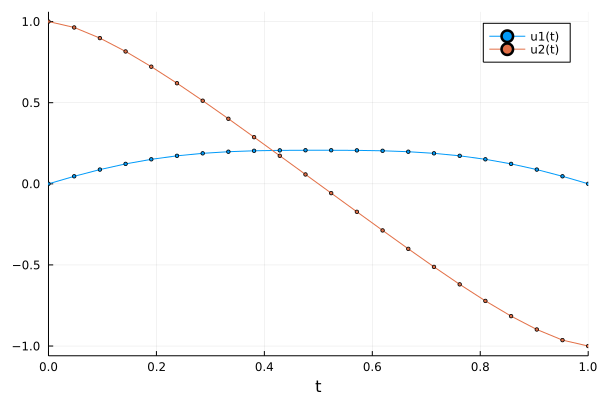

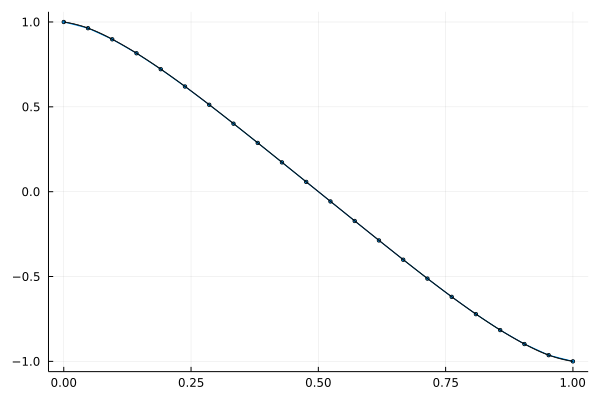

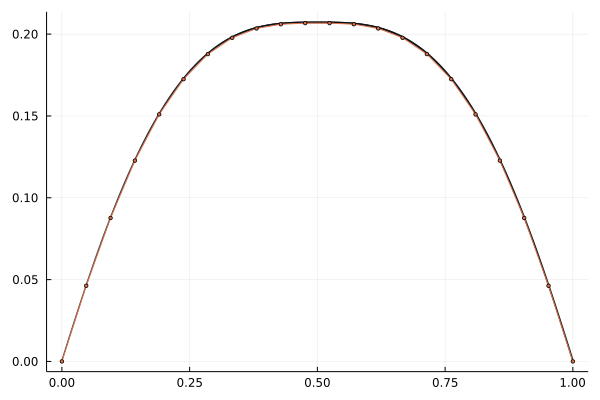

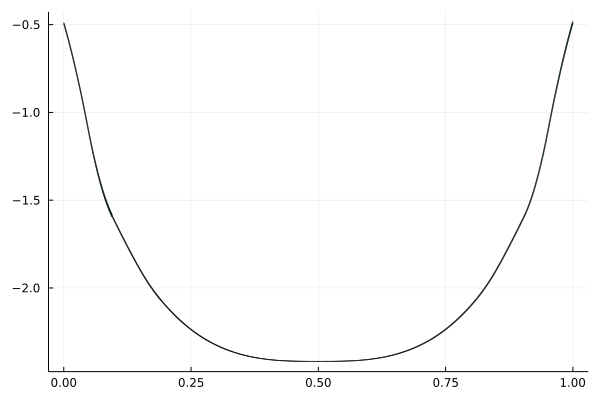

Numericky získané první vlastní číslo Λ₁=5.318718074184005


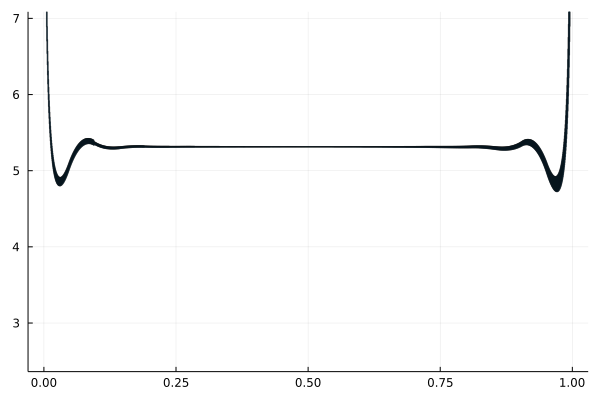

Dolní odhad λ₁ˡᵒʷ=4.72411787118738


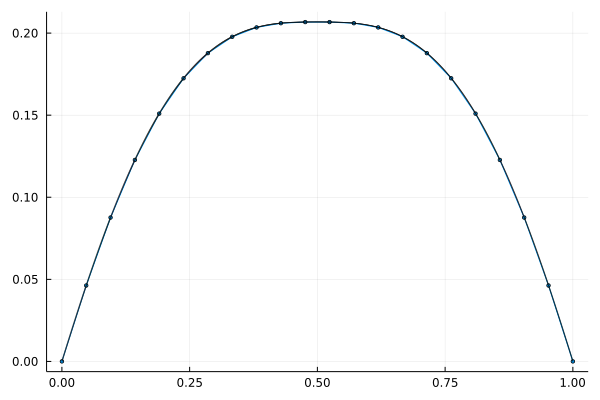

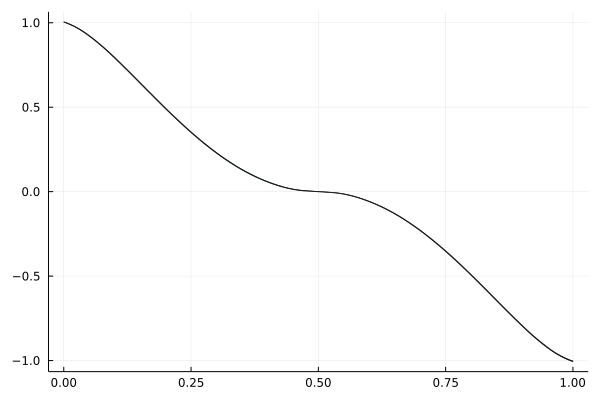

Chyba dolního odhadu proti přesné hodnotě λ₁ₚ: 0.5946002051917896
Horní odhad λ₁ᵘᵖ=5.3392447305557225
Chyba horního odhadu proti přesné hodnotě λ₁ₚ: 0.020526654176553194


In [8]:
p=1.5
λ₁ = (p-1)*(2*(π/p)/(sin(π/p)))^p

n = 22 # bodů dělení 
ns = 100 # bodů dělení jednotlivého oblouku spline
si = mince(0..1,(n-1)*ns) # intervaly dělení splinu
λᵢₙᵢₜ = (3.,8.); # interval na kterém hledáme λ₁ (nesmí obsahovat vyšší λᵢ)

### lower estimate
# 1st step
t, tᴵ, U₁, U₁ᴵ, U₂, U₂ᴵ, Λ₁ = plaplace_solve(λᵢₙᵢₜ, p, n);
# 2nd step
csc_U₂ˢ, U₂ˢ = cubic_spline(t, tᴵ, U₂, U₂ᴵ, -9.988, 10.131, ns=ns);
# 3rd step
U₁ˢ = get_u1(p,U₂ˢ, t, U₁);
# 4th step
U₂ˢ_der = der_cubic_spline(csc_U₂ˢ, t, tᴵ, ns);
# 5th step
λ₁ˡᵒʷ, Fˡᵒʷ = lower_estimate(U₂ˢ_der, U₁ˢ, p)
println("Chyba dolního odhadu proti přesné hodnotě λ₁ₚ: $(λ₁-λ₁ˡᵒʷ)")


### upper estimate
csc_U₁, U₁ˢ = cubic_spline(t, tᴵ, U₁, U₁ᴵ, -1, -1, ns=ns);
U₁ˢ_der = der_cubic_spline(csc_U₁, t, tᴵ, ns); 
λ₁ᵘᵖ = upper_estimate(p, U₁ˢ, U₁ˢ_der, plt_res=true);
println("Chyba horního odhadu proti přesné hodnotě λ₁ₚ: $(λ₁ᵘᵖ-λ₁)")

In [9]:
p=1.5
λ₁ = (p-1)*(2*(π/p)/(sin(π/p)))^p
println("Přesná hodnota λ₁ₚ=$λ₁")

n = 22
ns= 150000
si = mince(0..1,(n-1)*ns) # dělení splinu
λᵢₙᵢₜ = (3.,8.);

t, tᴵ, U₁, U₁ᴵ, U₂, U₂ᴵ, Λ₁ = plaplace_solve(λᵢₙᵢₜ, p, n, plt_res=false);
csc_U₂, U₂ˢ = cubic_spline(t, tᴵ, U₂, U₂ᴵ, -9.988, 10.131, ns=ns, plt_res=false);
U₁ˢ = get_u1(p,U₂ˢ, t, U₁, plt_res=false);
U₂ˢ_der = der_cubic_spline(csc_U₂, t, tᴵ, ns, plt_res=false);
λ₁ˡᵒʷ, Fˡᵒʷ = lower_estimate(U₂ˢ_der, U₁ˢ, p, plt_res=false);
println("Dolní odhad λ₁ˡᵒʷ=$λ₁ˡᵒʷ")
println("Chyba dolního odhadu proti přesné hodnotě λ₁ₚ: $(λ₁-λ₁ˡᵒʷ)")

csc_U₁, U₁ˢ = cubic_spline(t, tᴵ, U₁, U₁ᴵ, -1, -1, ns=ns, plt_res=false);
U₁ˢ_der = der_cubic_spline(csc_U₁, t, tᴵ, ns, plt_res=false); 
λ₁ᵘᵖ = upper_estimate(p, U₁ˢ, U₁ˢ_der, plt_res=false);
println("Horní odhad λ₁ᵘᵖ=$λ₁ᵘᵖ")
println("Chyba horního odhadu proti přesné hodnotě λ₁ₚ: $(λ₁ᵘᵖ-λ₁)")

Přesná hodnota λ₁ₚ=5.318718076379169
Dolní odhad λ₁ˡᵒʷ=4.878637563733907
Chyba dolního odhadu proti přesné hodnotě λ₁ₚ: 0.44008051264526227
Horní odhad λ₁ᵘᵖ=5.318745929231864
Chyba horního odhadu proti přesné hodnotě λ₁ₚ: 2.785285269446547e-5


In [10]:
p=3
λ₁ = (p-1)*(2*(π/p)/(sin(π/p)))^p
println("Přesná hodnota λ₁ₚ: $λ₁")

n = 22
ns = 150000
si = mince(0..1,(n-1)*ns)
λᵢₙᵢₜ = (3.,40.); 

t, tᴵ, U₁, U₁ᴵ, U₂, U₂ᴵ, Λ₁ = plaplace_solve(λᵢₙᵢₜ, p, n, plt_res=false);
#p=3: vlevo= +0.01065 , vpravo=-0.03425
csc_U₂, U₂ˢ = cubic_spline(t, tᴵ, U₂, U₂ᴵ, 0.01065, -0.034251, ns=ns, plt_res=false);
U₁ˢ = get_u1(p,U₂ˢ, t, U₁, plt_res=false);
U₂ˢ_der = der_cubic_spline(csc_U₂, t, tᴵ, ns, plt_res=false);
λ₁ˡᵒʷ, Fˡᵒʷ = lower_estimate(U₂ˢ_der, U₁ˢ, p, plt_res=false);
println("Dolní odhad λ₁ˡᵒʷ=$λ₁ˡᵒʷ")
println("Chyba dolního odhadu proti přesné hodnotě λ₁ₚ: $(λ₁-λ₁ˡᵒʷ)")

csc_U₁, U₁ˢ = cubic_spline(t, tᴵ, U₁, U₁ᴵ, -1, -1, ns=ns, plt_res=false);
U₁ˢ_der = der_cubic_spline(csc_U₁, t, tᴵ, ns, plt_res=false); 
λ₁ᵘᵖ = upper_estimate(p, U₁ˢ, U₁ˢ_der, plt_res=false);
println("Horní odhad λ₁ᵘᵖ=$λ₁ᵘᵖ")
println("Chyba horního odhadu proti přesné hodnotě λ₁ₚ: $(λ₁ᵘᵖ-λ₁)")

Přesná hodnota λ₁ₚ: 28.28876197600255
Dolní odhad λ₁ˡᵒʷ=28.116445280046513
Chyba dolního odhadu proti přesné hodnotě λ₁ₚ: 0.17231669595603805
Horní odhad λ₁ᵘᵖ=28.30375756411
Chyba horního odhadu proti přesné hodnotě λ₁ₚ: 0.01499558810744972


1106.854960 seconds (4.59 G allocations: 186.386 GiB, 2.47% gc time)


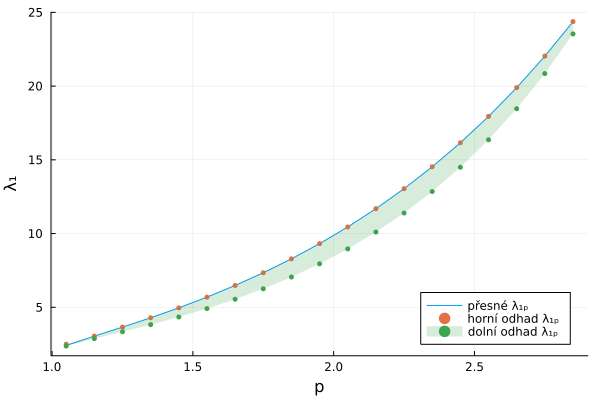

In [13]:
@time begin
    ps = 1.05:0.1:2.85

    n = 22 # kroků dělení
    ns = 10000 # dělení jednotlivého oblouku spline
    si = mince(0..1,(n-1)*ns) # dělení výsledného splinu

    λ₁s = []
    Λ₁s = []
    λ₁ˡᵒʷ = []
    λ₁ᵘᵖ = []

    for p in ps
        append!(λ₁s, (p-1)*(2*(π/p)/(sin(π/p)))^p)

        λᵢₙᵢₜ = (1.,λ₁s[end]+λ₁s[end]*0.5); 
        t, tᴵ, U₁, U₁ᴵ, U₂, U₂ᴵ, Λ₁ = plaplace_solve(λᵢₙᵢₜ, p, n, plt_res=false);
        append!(Λ₁s, Λ₁)
        csc_U₂, U₂ˢ = cubic_spline(t, tᴵ, U₂, U₂ᴵ, 0, 0, ns=ns, plt_res=false);

        #dolní odhad
        U₁ˢ = get_u1(p,U₂ˢ, t, U₁, plt_res=false);
        U₂ˢ_der = der_cubic_spline(csc_U₂, t, tᴵ, ns, plt_res=false);
        l1low, _ = lower_estimate(U₂ˢ_der, U₁ˢ, p, plt_res=false);
        append!(λ₁ˡᵒʷ, l1low)

        #horní odhad
        csc_U₁, U₁ˢ = cubic_spline(t, tᴵ, U₁, U₁ᴵ, -1, -1, ns=ns, plt_res=false);
        U₁ˢ_der = der_cubic_spline(csc_U₁, t, tᴵ, ns, plt_res=false); 
        l1up = upper_estimate(p, U₁ˢ, U₁ˢ_der, plt_res=false);
        append!(λ₁ᵘᵖ, l1up)
    end

    plot(ps, λ₁s, label="přesné λ₁ₚ")
    plot!(ps,λ₁ᵘᵖ, line = :scatter, msw = 0, ms = 3, label="horní odhad λ₁ₚ")
    plot!(ps,λ₁ˡᵒʷ, line = :scatter, msw = 0, ms = 3, 
        label="dolní odhad λ₁ₚ", fillrange = λ₁ᵘᵖ, fillalpha = 0.2, 
        c = 3, legend=:bottomright, xlabel="p", ylabel="λ₁")
end

In [15]:
λ₁s.-λ₁ˡᵒʷ

19-element Vector{Float64}:
 0.043604885294239004
 0.17163986844602475
 0.31416755233828253
 0.4647645188154228
 0.6200657362341646
 0.7774382718733595
 0.9342648304464367
 1.0875957429092553
 1.2339491679905397
 1.369120331176437
 1.4880558830163615
 1.5846848297588352
 1.6517743520597978
 1.6807090211058853
 1.6612685629942074
 1.5815190074900016
 1.4274633423710874
 1.182789241464313
 0.8285524855496647